
# Model Optimizations

### Importing statements

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

import joblib
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout,Input, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import json
from sklearn.model_selection import RandomizedSearchCV
import scipy
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, LSTM


## Data Loading

Loaded the save data that was saved after calculating sentiment score with sentiment for each row based on preprocessed text from distilbert transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Load the CSV file into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/mental-health-data/health_data_merged.csv')

# Display the first few rows of the DataFrame
data.head()

,index,Timestamp,Subreddit,Type,Post_id,Title,Author,Text,Score,Total_comments,...,hour,day_of_week,Sentiment,Title_word_count,Text_word_count,Category,Processed_Title,Processed_Text,Sentiment2,Sentiment_Score
0,42306,2022-08-04 06:20:31,mentalhealth,Comment,wfa03v,just found out someone whose mentally tortured...,Takeitoff3000,"Honestly all I can say is Congratulations, tha...",1.0,0.0,...,6,Thursday,positive,13,11,MH_Improvement,found someone whose mentally tortured year killed,honestly say congratulation thats fucking awesome,POSITIVE,0.999609
1,42307,2022-08-04 08:25:19,mentalhealth,Comment,wfa03v,just found out someone whose mentally tortured...,Yandereii,Bless you. I love when Karma finally shows. If...,1.0,0.0,...,8,Thursday,positive,13,13,MH_Improvement,found someone whose mentally tortured year killed,bless love karma finally show consistent,POSITIVE,0.999763
2,42308,2022-08-04 11:26:10,mentalhealth,Comment,wfa03v,just found out someone whose mentally tortured...,Unknown,FUCK YEAHHH,1.0,0.0,...,11,Thursday,negative,13,2,MH_Improvement,found someone whose mentally tortured year killed,fuck yeahhh,NEGATIVE,0.908888
3,42309,2022-08-03 18:15:22,mentalhealth,Comment,wfa03v,just found out someone whose mentally tortured...,thesnapening,Yep the police tweeted about having respect fo...,56.0,0.0,...,18,Wednesday,negative,13,25,MH_Improvement,found someone whose mentally tortured year killed,yep police tweeted respect family sad time tem...,NEGATIVE,0.994511
4,42310,2022-08-04 02:20:04,mentalhealth,Comment,wfa03v,just found out someone whose mentally tortured...,wonderlandisgone,Or when everyone just lies and says how amazin...,3.0,0.0,...,2,Thursday,negative,13,44,MH_Improvement,found someone whose mentally tortured year killed,everyone lie say amazing like someone died mea...,NEGATIVE,0.992835


In [ ]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82568 entries, 0 to 82567
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             82568 non-null  int64  
 1   Timestamp         82568 non-null  object 
 2   Subreddit         82568 non-null  object 
 3   Type              82568 non-null  object 
 4   Post_id           82568 non-null  object 
 5   Title             82568 non-null  object 
 6   Author            82568 non-null  object 
 7   Text              82568 non-null  object 
 8   Score             82568 non-null  float64
 9   Total_comments    82568 non-null  float64
 10  month             82568 non-null  int64  
 11  hour              82568 non-null  int64  
 12  day_of_week       82568 non-null  object 
 13  Sentiment         82568 non-null  object 
 14  Title_word_count  82568 non-null  int64  
 15  Text_word_count   82568 non-null  int64  
 16  Category          82568 non-null  object

In [ ]:
data.isnull().sum()

,0
index,0
Timestamp,0
Subreddit,0
Type,0
Post_id,0
Title,0
Author,0
Text,0
Score,0
Total_comments,0


> There are no missing values

## Model Training

Here we ghave taken the relevent where I have replaced Sentiment calculated with distilbert TRANSFORMER instead of VADER SENTIMENT ANALYSER

In [ ]:
relevant_columns = [
    'Title_word_count', 'Text_word_count',
    'Score', 'Total_comments','Sentiment2' ,'Processed_Title', 'Processed_Text','Sentiment_Score'
]


Later divided the columns into features and target variable and applied text vectorization, label_encoding to categorical variables, scaling numerical columns

In [ ]:
# Selecting relevant data for X
X = data[relevant_columns]
y = data['Category']

# Text vectorization for 'Processed_Title' and 'Processed_Text'
vectorizer_title = TfidfVectorizer(max_features=1000)
vectorizer_text = TfidfVectorizer(max_features=5000)


# Label encoding for categorical variables
label_encoder = LabelEncoder()
X['Sentiment2'] = label_encoder.fit_transform(X['Sentiment2'])

# Standardizing numerical columns
scaler = StandardScaler()

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [ ]:

# Vectorizing text features for training data
X_train_title_tfidf = vectorizer_title.fit_transform(X_train['Processed_Title'])
X_train_text_tfidf = vectorizer_text.fit_transform(X_train['Processed_Text'])

X_test_title_tfidf = vectorizer_title.transform(X_test['Processed_Title'])
X_test_text_tfidf = vectorizer_text.transform(X_test['Processed_Text'])

# Dropping the original text columns (since they are now vectorized)
X_train = X_train.drop(columns=['Processed_Title', 'Processed_Text'])
X_test = X_test.drop(columns=['Processed_Title', 'Processed_Text'])

In [ ]:


# Scaling numerical columns
X_train[['Title_word_count', 'Text_word_count', 'Score','Sentiment_Score', 'Total_comments']] = scaler.fit_transform(
    X_train[['Title_word_count', 'Text_word_count', 'Score', 'Sentiment_Score','Total_comments']]
)
X_test[['Title_word_count', 'Text_word_count', 'Score', 'Sentiment_Score','Total_comments']] = scaler.transform(
    X_test[['Title_word_count', 'Text_word_count', 'Score','Sentiment_Score', 'Total_comments']]
)

In [ ]:

# Concatenating vectorized text data with the other features
import scipy
X_train_combined = scipy.sparse.hstack([X_train, X_train_title_tfidf, X_train_text_tfidf])
X_test_combined = scipy.sparse.hstack([X_test, X_test_title_tfidf, X_test_text_tfidf])

In [ ]:
import joblib
import os

# Directory to save the models
model_dir = '/content/drive/MyDrive/mental-health-data/saved_models'
os.makedirs(model_dir, exist_ok=True)

## Traditional ML MODELS

### Logistic Regression

In [ ]:

# Function to save and evaluate model
def train_save_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train_combined, y_train)

    # Save the trained model
    model_path = os.path.join(model_dir, f'{model_name}.joblib')
    joblib.dump(model, model_path)
    print(f"{model_name} saved to {model_path}")

    # Evaluate the model
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))

In [ ]:

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
train_save_evaluate_model(logistic_model, 'logistic_regression')

logistic_regression saved to /content/drive/MyDrive/mental-health-data/saved_models/logistic_regression.joblib
logistic_regression Accuracy: 0.99
Classification Report for logistic_regression:
                 precision    recall  f1-score   support

  MH_Disorders       1.00      0.49      0.66        49
   MH_Distress       0.99      0.96      0.97      7517
MH_Improvement       0.99      1.00      0.99     25462

      accuracy                           0.99     33028
     macro avg       0.99      0.82      0.87     33028
  weighted avg       0.99      0.99      0.99     33028



### Random Forest Classifier


In [ ]:

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_save_evaluate_model(model=rf_model, model_name='random_forest')


random_forest saved to /content/drive/MyDrive/mental-health-data/saved_models/random_forest.joblib
random_forest Accuracy: 0.99
Classification Report for random_forest:
                 precision    recall  f1-score   support

  MH_Disorders       1.00      0.67      0.80        49
   MH_Distress       0.99      0.99      0.99      7517
MH_Improvement       1.00      1.00      1.00     25462

      accuracy                           0.99     33028
     macro avg       0.99      0.89      0.93     33028
  weighted avg       0.99      0.99      0.99     33028



# Deep Learning Models

### Variable and Data Preparation for CNN Models

Assined parametes, tokenized the texts , label_encoding to categorical variables, scaling numerical columns

In [ ]:
# Parameters
max_vocab_size = 20000
max_sequence_length = 100
embedding_dim = 50

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(data['Processed_Text'].values)
X_text = tokenizer.texts_to_sequences(data['Processed_Text'].values)
X_text = pad_sequences(X_text, maxlen=max_sequence_length)


In [ ]:
# relevant columns and separate categorical from numerical columns
relevant_columns = [
    'Title_word_count', 'Text_word_count',
    'Score', 'Total_comments','Sentiment2','Sentiment_Score'
]
numerical_columns = ['Title_word_count', 'Text_word_count', 'Score', 'Total_comments','Sentiment_Score']
categorical_columns = ['Sentiment2']

# Scaling the numerical features
X_numerical = data[numerical_columns]
scaler = StandardScaler()
X_numerical = scaler.fit_transform(X_numerical)

# Encoding the categorical features
label_encoder = LabelEncoder()
X_categorical = label_encoder.fit_transform(data['Sentiment2'])

# Combining numerical and categorical features
X_additional = np.concatenate([X_numerical, X_categorical.reshape(-1, 1)], axis=1)



In [ ]:

# Concatenate text and additional features along the second axis
X_combined = np.concatenate([X_text, X_additional], axis=1)

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Category'].values)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


## Hybrid CNN
Hybrid CNN  combines a CNN-based text-processing pipeline (embedding, Conv1D, pooling) with an additional input layer for non-text features, which are then concatenated and passed into a fully connected layer.

This is a multimodal neural network model using the Keras API in TensorFlow, combining text data with additional numeric or categorical features for a multi-class classification task.




In [ ]:

# Define the inputs for the model -- Accepts text data sequences, processed through an embedding and convolutional layer.
text_input = Input(shape=(max_sequence_length,))
additional_input = Input(shape=(X_additional.shape[1],)) # Accepts text data sequences, processed through an embedding and convolutional layer.

# Text processing layers (embedding and convolution for text data)
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(text_input) # Converts words into dense vectors of fixed size.
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer) #  Applies a 1D convolution over the text embeddings, extracting features.

pooling_layer = GlobalMaxPooling1D()(conv_layer) # Reduces the output from the convolution layer, capturing the most salient features.

# Concatenate text and additional inputs
concatenated = Concatenate()([pooling_layer, additional_input])

# Fully connected layers
dense_layer = Dense(32, activation='relu')(concatenated) # Adds a fully connected layer with 32 units for learning more complex patterns.
dropout_layer = Dropout(0.7)(dense_layer) # Applies dropout to prevent overfitting.
output_layer = Dense(4, activation='softmax')(dropout_layer)  #Produces a 4-class softmax output, suitable for a multi-class classification problem.


# Compile the model -- Uses the Adam optimizer and sparse_categorical_crossentropy loss, with accuracy as the evaluation metric.

model = Model(inputs=[text_input, additional_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Model summary
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 50)        │      1,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 96, 128)        │         32,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 134)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          4,320 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            132 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,036,580 (3.95 MB)

 Trainable params: 1,036,580 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

The architecture includes:
Input Layer: Handles sequences of length 100 for the main input and 6 additional features for auxiliary input.
Embedding Layer: Converts tokens into a 50-dimensional embedding space, with 1M trainable parameters.
Conv1D Layer: Performs feature extraction with 128 filters, detecting patterns within the embeddings.
Global Max Pooling: Reduces dimensionality while retaining the most important features.
Dense Layers: Combines features from the main and auxiliary inputs for classification.
Dropout: Adds regularization to reduce overfitting.
This architecture effectively combines text-based features with auxiliary inputs for multi-class classification tasks.

In [ ]:
# Set up checkpointing to save model weights
checkpoint_dir = '/content/drive/MyDrive/mental-health-data/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)


# Early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=4,          # Stop after 1 epoch with no improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    verbose=1
)

# Train the model and save history
history = model.fit(
    [X_train[:, :max_sequence_length], X_train[:, max_sequence_length:]],  # Adjust input data as needed
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save training history
history_path = 'training_history.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_path}")



Epoch 1/10
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7859 - loss: 0.5548
Epoch 1: val_accuracy improved from -inf to 0.91681, saving model to /content/drive/MyDrive/mental-health-data/checkpoints/model-01-0.92.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7859 - loss: 0.5547 - val_accuracy: 0.9168 - val_loss: 0.2339
Epoch 2/10
1630/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.2524
Epoch 2: val_accuracy improved from 0.91681 to 0.93316, saving model to /content/drive/MyDrive/mental-health-data/checkpoints/model-02-0.93.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9128 - loss: 0.2524 - val_accuracy: 0.9332 - val_loss: 0.2027
Epoch 3/10
1645/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9365 - loss: 0.1794
Epoch 3: val_accuracy improved from 0.93316 to 0.94073, saving model to /content/drive/MyDrive/mental-health-data/checkpoints/model-03-0.94.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - ac

In [ ]:
# # Reload model from checkpoint
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# if latest_checkpoint:
#     model.load_weights(latest_checkpoint)
#     print(f"Loaded model from {latest_checkpoint}")

# # Continue training if needed
# model.fit(
#     X_train, y_train,
#     epochs=5,  # Add more epochs as needed
#     validation_split=0.2,
#     batch_size=32
# )

# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)



In [ ]:
# Split X_test into text and additional features
X_test_text = X_test[:, :max_sequence_length]           # Text input
X_test_additional = X_test[:, max_sequence_length:]     # Additional features input

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9354 - loss: 0.2006
Test Accuracy: 0.93


In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))


Training and Validation Accuracy: [0.8532634377479553, 0.9138012528419495, 0.9384402632713318, 0.95585036277771, 0.9657286405563354, 0.9753609895706177, 0.9766477942466736] [0.9168117642402649, 0.933161735534668, 0.9407312273979187, 0.9436076283454895, 0.9501173496246338, 0.9523124694824219, 0.9520853757858276]


The test accuracy is 93.54%, close to the validation accuracy of 95.21%, indicating good generalization to unseen data.
The test loss of 0.2006 aligns well with the validation loss, further confirming the model's robust performance.

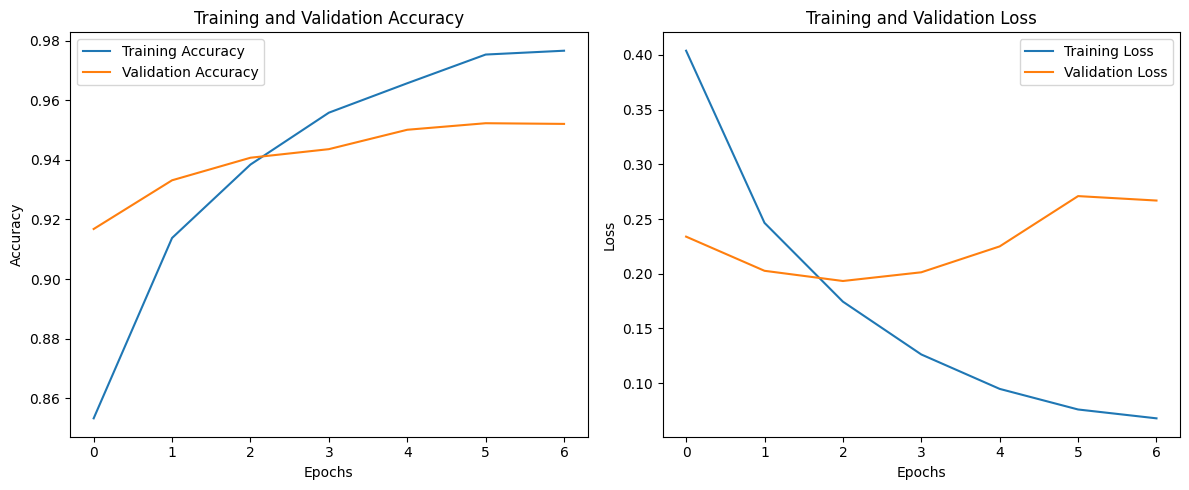

In [ ]:


# Load training history
history_path = 'training_history.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


Training Accuracy starts at 85.32% and increases steadily to 97.66%, showing effective learning on the training data.
Validation Accuracy starts at 91.68% and stabilizes at 95.21%. The improvement rate decreases after Epoch 4, indicating the model is reaching its generalization limit.
Training Loss reduces significantly from 0.5548 to 0.0636, showing successful error minimization during training.
Validation Loss decreases initially but begins to increase slightly after Epoch 4, rising from 0.1934 to 0.2669 at Epoch 7. This divergence suggests mild overfitting in the later epochs.



In [ ]:
# Set up checkpointing to save model weights
checkpoint_dir = '/content/drive/MyDrive/mental-health-data/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model1-50-{epoch:02d}-{val_accuracy:.2f}.weights.h5")  # Changed extension to .weights.h5
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)

# Early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Stop after 1 epoch with no improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    verbose=1
)

# Train the model and save history
history = model.fit(
    [X_train[:, :max_sequence_length], X_train[:, max_sequence_length:]],  # Adjust input data as needed
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save training history
history_path = 'training_history50.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_path}")


Epoch 1/50
1645/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9559 - loss: 0.1264
Epoch 1: val_accuracy improved from -inf to 0.94641, saving model to /content/drive/MyDrive/mental-health-data/checkpoints/model1-50-01-0.95.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9559 - loss: 0.1264 - val_accuracy: 0.9464 - val_loss: 0.2201
Epoch 2/50
1643/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9666 - loss: 0.0904
Epoch 2: val_accuracy did not improve from 0.94641
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9666 - loss: 0.0904 - val_accuracy: 0.9435 - val_loss: 0.2153
Epoch 3/50
1644/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9705 - loss: 0.0773
Epoch 3: val_accuracy improved from 0.94641 to 0.94966, saving model to /content/drive/MyDrive/mental-health-data/checkpoints/model1-50-03-0.95.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9705 - loss: 0.0773 - val_accuracy: 0.9497 - val_loss: 0.2502
Epoch 4/50
1637/1652 

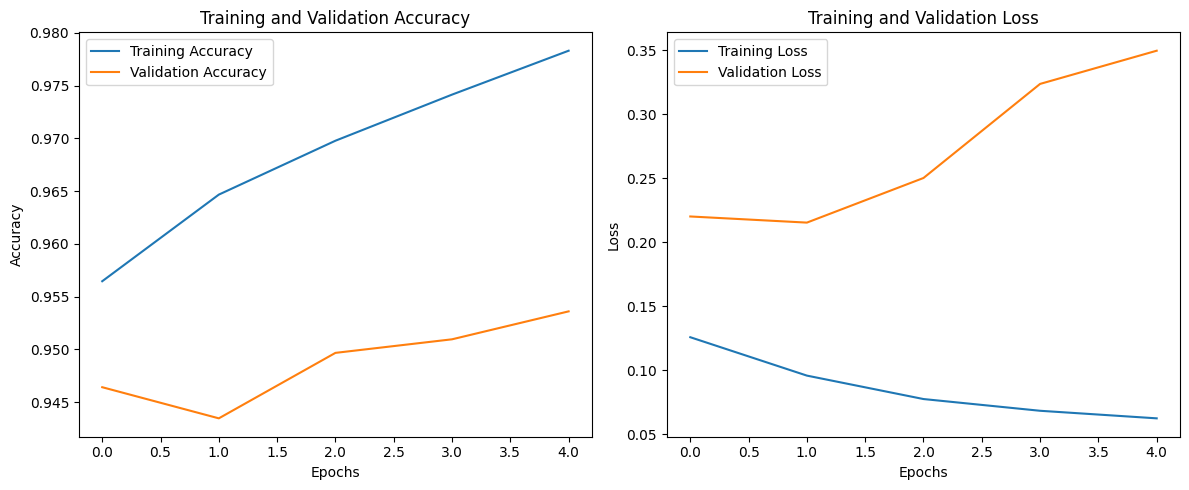

In [ ]:


# Load training history
history_path = 'training_history50.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

* Training Accuracy: The model consistently improves across epochs, reaching a high of 97.83% at Epoch 5.
This shows that the model is learning effectively from the training data and has a strong ability to classify training samples correctly.
* Validation Accuracy starts at 94.64%, decreases slightly in Epoch 2 (94.34%), and gradually increases, peaking at 95.36% in Epoch 5.
This reflects good generalization to unseen data but shows minor fluctuations, potentially due to noise or small dataset variance.
* Training Loss decreases steadily from 0.1264 to 0.0593, indicating effective minimization of the loss function.
* Validation Loss decreases initially but begins to increase after Epoch 3, rising from 0.2502 to 0.3497 by Epoch 5.
This increase in validation loss despite improving validation accuracy suggests mild overfitting or a plateau in the model's generalization ability.

* The divergence between validation loss and validation accuracy could indicate that the loss function penalizes certain predictions more heavily, even if accuracy improves. This might require further analysis of class-wise predictions or weighting adjustments in the loss function.


In [ ]:
# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)

In [ ]:
# Split X_test into text and additional features
X_test_text = X_test[:, :max_sequence_length]           # Text input
X_test_additional = X_test[:, max_sequence_length:]     # Additional features input

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9422 - loss: 0.2261
Test Accuracy: 0.94


In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))


Training and Validation Accuracy: [0.9564559459686279, 0.9646689295768738, 0.9697784185409546, 0.9741498231887817, 0.9783130884170532] [0.9464082717895508, 0.94345623254776, 0.9496631622314453, 0.9509499669075012, 0.9535992741584778]


The test accuracy is 94.22%, which is close to the validation accuracy (95.36%).
This consistency between validation and test accuracies indicates good generalization and supports the conclusion that the model performs reliably on unseen data.

## Kim’s CNN Model

- The model includes multiple convolution layers with different filter sizes (3, 4, and 5), which is a hallmark of Kim's model. This approach allows it to identify various n-gram features from the text data.
- Each convolutional layer is followed by Global Max Pooling, as in Kim’s original model, which selects the most main feature from each feature map.
- This model is hybrid because it incorporates additional non-textual input (using the additional_input layer).This hybrid structure enables the model to learn from both text and non-text data simultaneously.

In [ ]:

# Define inputs for text and additional features
text_input = Input(shape=(max_sequence_length,), name="text_input")
additional_input = Input(shape=(X_additional.shape[1],), name="additional_input")

# Embedding layer
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=64, input_length=max_sequence_length)(text_input)

# Multiple Conv1D layers with different filter sizes (Kim's model)
conv_3 = Conv1D(64, 3, activation='relu')(embedding_layer)
conv_4 = Conv1D(64, 4, activation='relu')(embedding_layer)
conv_5 = Conv1D(64, 5, activation='relu')(embedding_layer)

# Global Max Pooling for each convolution layer
pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Concatenate all pooled features
concatenated = Concatenate()([pool_3, pool_4, pool_5, additional_input])

# Fully connected layers
dense_layer = Dense(32, activation='relu')(concatenated)
dropout_layer = Dropout(0.7)(dense_layer)
output_layer = Dense(4, activation='softmax')(dropout_layer)  # Multi-class classification (4 classes)

# Compile the model with appropriate loss for multi-class classification
model_kim = Model(inputs=[text_input, additional_input], outputs=output_layer)
model_kim.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_kim.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 64)        │      1,280,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 98, 64)         │         12,352 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 97, 64)         │         16,448 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 96, 64)         │         20,544 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 64)             │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 64)             │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 64)             │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_input          │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 198)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ additional_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          6,368 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            132 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,335,844 (5.10 MB)

 Trainable params: 1,335,844 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

The architecture is a hybrid model combining:
1D Convolutional Layers: These extract features from the text input.
Global Max Pooling: Helps reduce the dimensionality while retaining important features.
Additional Inputs: Suggests integration of auxiliary features (likely categorical or numeric data).
Fully Connected Dense Layers: Used for combining features and final classification.
Dropout Layer: Used to prevent overfitting by randomly deactivating neurons during training.
This architecture is well-suited for text-based multi-class classification tasks with auxiliary data.

In [ ]:
# Split X_train and X_test into separate inputs for training and testing
X_train_text = X_train[:, :max_sequence_length]           # Text input
X_train_additional = X_train[:, max_sequence_length:]     # Additional features input

# Set up checkpointing and early stopping
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "modelkim-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_kim = model_kim.fit(
    [X_train_text, X_train_additional],  # Provided text and additional inputs separately
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save the training history
history_path = 'kim_cnn_history.json'
with open(history_path, 'w') as f:
    json.dump(history_kim.history, f)
print(f"Training history saved to {history_path}")

# Prepare test data for evaluation
X_test_text = X_test[:, :max_sequence_length]
X_test_additional = X_test[:, max_sequence_length:]

# Evaluate the model on test data
test_loss, test_accuracy = model_kim.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")



Epoch 1/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7912 - loss: 0.5393
Epoch 1: val_accuracy improved from -inf to 0.91878, saving model to ./checkpoints/modelkim-01-0.92.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7913 - loss: 0.5392 - val_accuracy: 0.9188 - val_loss: 0.2463
Epoch 2/50
1643/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.2675
Epoch 2: val_accuracy improved from 0.91878 to 0.92900, saving model to ./checkpoints/modelkim-02-0.93.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8950 - loss: 0.2675 - val_accuracy: 0.9290 - val_loss: 0.2085
Epoch 3/50
1634/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9290 - loss: 0.1882
Epoch 3: val_accuracy improved from 0.92900 to 0.93369, saving model to ./checkpoints/modelkim-03-0.93.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9291 - loss: 0.1882 - val_accuracy: 0.9337 - val_loss: 0.1978
Epoch 4/50
1644/1652 ━━━━━━━━━━━━━━━━━

In [ ]:
# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)

In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))

Training and Validation Accuracy: [0.8369131088256836, 0.9015952944755554, 0.9331983327865601, 0.9572318196296692, 0.9668073058128357, 0.9727305173873901] [0.9187797904014587, 0.928998589515686, 0.9336916208267212, 0.9448944330215454, 0.9502686858177185, 0.9523124694824219]


The final test accuracy is 94%, which aligns closely with the validation accuracy. This suggests that the model generalizes well to unseen data, with minimal overfitting.


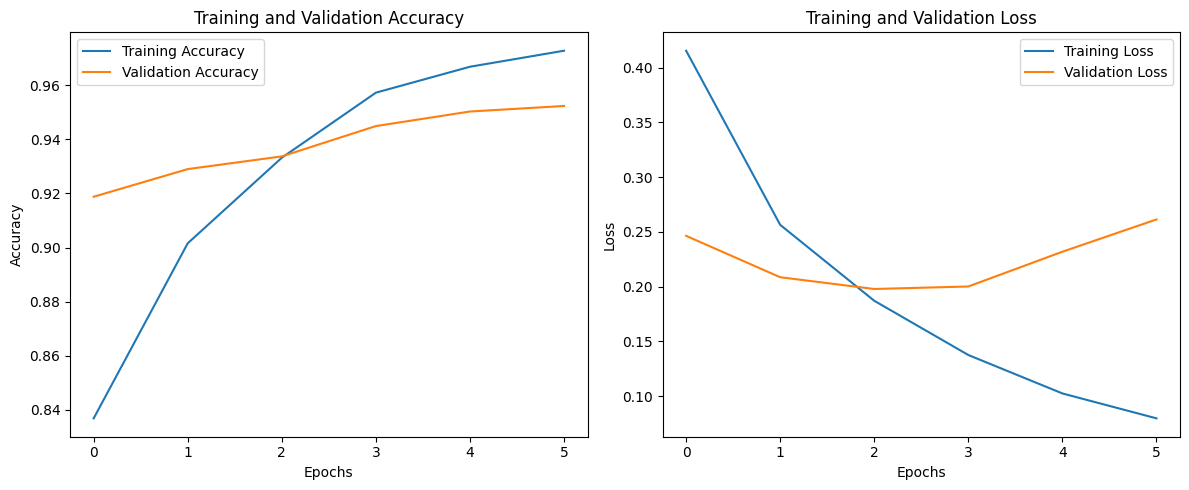

In [ ]:


# Load training history
history_path = 'kim_cnn_history.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

1. Accuracy and Loss Trends
* Training Accuracy steadily improves across epochs, starting from 83.69% in Epoch 1 and reaching 97.27% in Epoch 6. This indicates that the model is learning effectively and fitting well to the training data.
* Validation Accuracy shows a similarly increasing trend but with diminishing gains after Epoch 4. It improves from 91.88% in Epoch 1 to 95.23% in Epoch 6. This suggests strong generalization but also indicates that the model might be nearing its optimal performance on the validation set.
* * Training Loss decreases steadily, starting at 0.5393 and dropping to 0.0784 in Epoch 6. This aligns with the increasing training accuracy.
Validation Loss decreases initially (indicating effective learning) but starts to fluctuate slightly after Epoch 3, rising from 0.2001 to 0.2613 by Epoch 6. This indicates slight overfitting in the later epochs.


* The increasing gap between training and validation accuracy (and the slight rise in validation loss after Epoch 3) suggests slight overfitting as the model optimizes more for the training data.
* Despite slight overfitting, the validation and test accuracies remain consistently high, indicating good generalization to unseen data.

# Recurrent Neural Network (RNN) with LSTM

- This model is a hybrid LSTM model combining both text data (processed through an LSTM layer) and additional non-text features.
- The LSTM layer is part of the broader RNN family of models, which are designed to process sequential data by retaining information from previous time steps.
- LSTMs are well-suited for text as they can retain information over longer sequences, making them useful for tasks like sentiment analysis, sequence classification, or any task that benefits from understanding word order and context.
- Since this model combines an LSTM layer with additional non-text features, it is as a hybrid LSTM-based RNN model.






In [ ]:


# Define inputs for text and additional features
text_input = Input(shape=(max_sequence_length,), name="text_input")
additional_input = Input(shape=(X_additional.shape[1],), name="additional_input")

# Embedding layer with LSTM
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=32, input_length=max_sequence_length)(text_input) # Transforms the text input into dense embeddings.
lstm_layer = LSTM(32)(embedding_layer)  # Use a single LSTM layer -  Processes the embeddings sequentially, capturing temporal or sequential dependencies in the text data.

# Concatenate LSTM output with additional features
concatenated = Concatenate()([lstm_layer, additional_input]) # This model takes a second input for additional features (numeric or categorical), which are concatenated with the LSTM output.


# Dense layer
dense_layer = Dense(32, activation='relu')(concatenated)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(4, activation='softmax')(dropout_layer)

# Compile model
model = Model(inputs=[text_input, additional_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 32)        │        640,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)             │          8,320 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_input          │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 38)             │              0 │ lstm[0][0],            │
│ (Concatenate)             │                        │                │ additional_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          1,248 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 4)              │            132 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 649,700 (2.48 MB)

 Trainable params: 649,700 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split X_train and X_test into separate inputs for training and testing
X_train_text = X_train[:, :max_sequence_length]           # Text input
X_train_additional = X_train[:, max_sequence_length:]     # Additional features input

# Set up checkpointing and early stopping
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "modelkim-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_kim = model.fit(
    [X_train_text, X_train_additional],  # Provided text and additional inputs separately
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save the training history
history_path = 'rnn_lstm_history.json'
with open(history_path, 'w') as f:
    json.dump(history_kim.history, f)
print(f"Training history saved to {history_path}")

# Prepare test data for evaluation
X_test_text = X_test[:, :max_sequence_length]
X_test_additional = X_test[:, max_sequence_length:]

# Evaluate the model on test data
test_loss, test_accuracy = model_kim.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")



Epoch 1/50
1645/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7782 - loss: 0.5686
Epoch 1: val_accuracy improved from -inf to 0.92037, saving model to ./checkpoints/modelkim-01-0.92.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7786 - loss: 0.5677 - val_accuracy: 0.9204 - val_loss: 0.2356
Epoch 2/50
1649/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9199 - loss: 0.2345
Epoch 2: val_accuracy improved from 0.92037 to 0.93021, saving model to ./checkpoints/modelkim-02-0.93.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9199 - loss: 0.2345 - val_accuracy: 0.9302 - val_loss: 0.2086
Epoch 3/50
1651/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9354 - loss: 0.1869
Epoch 3: val_accuracy improved from 0.93021 to 0.93271, saving model to ./checkpoints/modelkim-03-0.93.weights.h5
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9354 - loss: 0.1869 - val_accuracy: 0.9327 - val_loss: 0.2036
Epoch 4/50
1651/1652 ━━━━━━━━━━━━━━━━

In [ ]:
# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)

In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))

Training and Validation Accuracy: [0.8618360161781311, 0.9214465618133545, 0.9344662427902222, 0.9440039396286011, 0.9503434896469116, 0.9560017585754395, 0.9609408974647522, 0.9646121263504028] [0.9203693866729736, 0.9302096962928772, 0.9327076077461243, 0.9350541234016418, 0.9367951154708862, 0.9418666362762451, 0.9399742484092712, 0.9412610530853271]


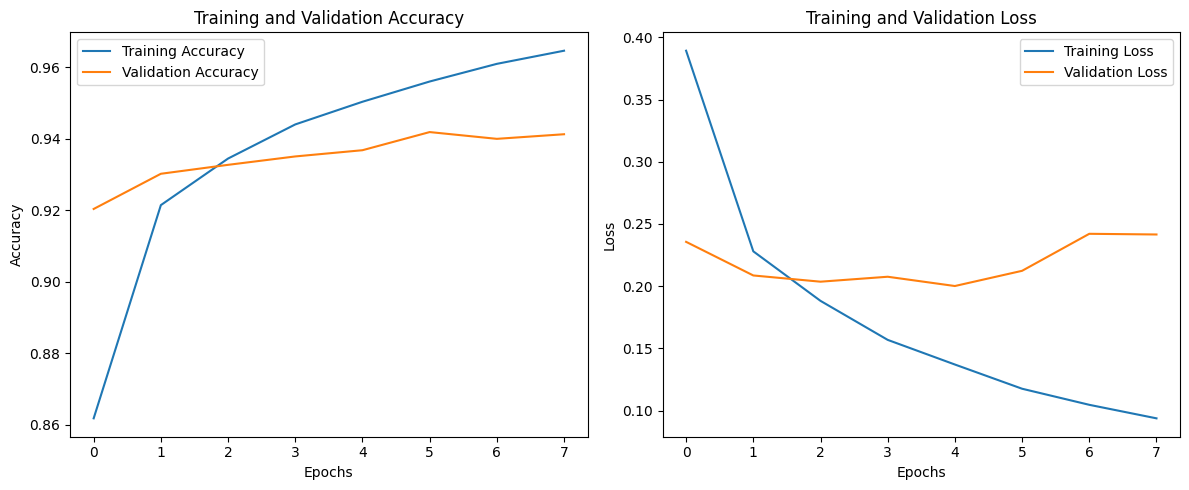

In [ ]:


# Load training history
history_path = 'rnn_lstm_history.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

* Training Accuracy steadily increases across epochs, indicating that the model is learning effectively on the training data.
By the end of training, the accuracy is close to 96%, suggesting the model performs well on the training dataset.

* Validation accuracy improves initially, peaking around epoch 3–4. After that, it remains relatively stable, showing no significant improvements, possibly indicating the model is approaching its generalization limit for this data.

* Training Loss decreases consistently, which aligns with the improvement in training accuracy.
This shows the model is minimizing its error on the training dataset effectively.

* Validation Loss decreases initially but starts fluctuating and slightly increasing after epoch 3–4.
This could indicate the model is starting to overfit the training data.

## Conclusion

In [1]:
from IPython.core.display import display, HTML

html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {
      font-family: Arial, sans-serif;
    }
    table {
      width: 80%;
      border-collapse: collapse;
      margin: 20px 0;
      font-size: 18px;
      text-align: left;
    }
    table th, table td {
      padding: 12px;
      border: 1px solid #ddd;
    }
    table th {
      background-color: #2980b9;
      color: white;
    }
    table tr:nth-child(even) {
      background-color: lightblue;
      color: black;
    }
    h2 {
      color: green;
    }
  </style>
</head>
<body>
  <h2>MODEL EVALUATION</h2>
  <h3>DistilBERT TRANSFORMER</h3>
  <p>Transformer-based deep learning model capable of capturing contextual sentiment nuances.</p>
  <table>
    <tr>
      <th>Models</th>
      <th>Training Accuracy</th>
      <th>Testing Accuracy</th>
      <th>Validation Accuracy</th>
    </tr>
    <tr>
      <td><strong>Hybrid CNN</strong></td>
      <td>97.6%</td>
      <td>93.55%</td>
      <td>95.21%</td>
    </tr>
    <tr>
      <td><strong>KIM CNN</strong></td>
      <td>97.2%</td>
      <td>94.5%</td>
      <td>95.23%</td>
    </tr>
    <tr>
      <td><strong>RNN CNN</strong></td>
      <td>96.5%</td>
      <td>94.5%</td>
      <td>94.1%</td>
    </tr>
     </table>
     <h3>VADER SENTIMENT ANALYSER</h3>
     <p>Rule-based approach with simple heuristics and limited contextual understanding, especially for nuanced or complex text inputs.</p>
      <table>
      <tr>
      <th>Models</th>
      <th>Training Accuracy</th>
      <th>Testing Accuracy</th>
      <th>Validation Accuracy</th>
    </tr>
    <tr>
      <td><strong>Hybrid CNN</strong></td>
      <td>77.5%</td>
      <td>71.6%</td>
      <td>70.6%</td>
    </tr>
    <tr>
      <td><strong>KIM CNN</strong></td>
      <td>76.3%</td>
      <td>71.1%</td>
      <td>71.1%</td>
    </tr>
    <tr>
      <td><strong>RNN CNN</strong></td>
      <td>75.9%</td>
      <td>71.1%</td>
      <td>72.1%</td>
    </tr>
  </table>
</body>
</html>
"""

display(HTML(html_content))

Models,Training Accuracy,Testing Accuracy,Validation Accuracy
Hybrid CNN,97.6%,93.55%,95.21%
KIM CNN,97.2%,94.5%,95.23%
RNN CNN,96.5%,94.5%,94.1%
Models,Training Accuracy,Testing Accuracy,Validation Accuracy
Hybrid CNN,77.5%,71.6%,70.6%
KIM CNN,76.3%,71.1%,71.1%
RNN CNN,75.9%,71.1%,72.1%


## Vader sentiment Analyser Work:
* Included the columns: ['Title_word_count', 'Text_word_count', 'Score', 'Total_comments', 'Sentiment', 'Processed_Title', 'Processed_Text'].
* The Sentiment column was derived from VADER Sentiment Analysis achieved an accuracy of 70–75% with significant overfitting (large gaps between training and validation metrics). Validation loss diverged noticeably after a few epochs, indicating poor generalization.

## DistilBERT Transformer Work:
* Added  Sentiment_Score and sentiment generated using DistilBERT (fine-tuned on SST-2), a transformer-based deep learning model for sentiment classification.
* The columns used were: ['Title_word_count', 'Text_word_count', 'Score', 'Total_comments', 'Sentiment2', 'Processed_Title', 'Processed_Text', 'Sentiment_Score'].
* Achieved significantly higher validation accuracy (95%) and test accuracy (93%).Moreover overfitting was minimized, with validation metrics closely aligned with test metrics, indicating improved generalization.
* Validation loss showed minor divergence after early epochs but was controlled effectively through early stopping.

## Conclusion

* Using Sentiment_Score  and sentiment from DistilBERT significantly boosted model accuracy, increasing it from 70–75% in the previous work to 95% validation accuracy and 93% test accuracy in the current work.

* The addition of Sentiment_Score improved the model's ability to generalize to unseen data, by closely aligned training, validation, and test metrics.

* Overfitting was decreased by adding features that better captured the semantic meaning of text, along with the use of dropout regularization and early stopping.

* In the current work, validation loss was controlled effectively, although it showed minor increases in later epochs. With early stopping I was able to achieve optimal performance without further divergence.

* Features like Title_word_count, Text_word_count, Score, and Total_comments provided useful auxiliary information that complemented the textual features, improving the overall performance in both approaches.




>This approach, using DistilBERT fine-tuned on SST-2, showed significant improvement in both accuracy and generalization compared to the previous work using VADER Sentiment Analysis.